In [1]:
%matplotlib inline
%load_ext autoreload 
%autoreload 2

import os
import sys
import copy 
import warnings
import cProfile

from time import time

from astropy.table import Table, Column, vstack

import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.rc('text', usetex=True)

### Visualize the student-T distribution as prior for the slope of the scaling relation

In [289]:
from asap import priors, parameters

# Parameters are described by a dictionary, which can be loaded from `yaml` configuration file.
# The format of the config for parameter is:

"""
parameter_1:
    name : 'a'
    label : 'a'
    type : 'flat'
    ini : 0.0
    sig : 1.0
    min : -1.0
    max : 1.0
"""

# For example, here are two parameters
#    a : flat distribution between 0.0 and 1.0; use the min and max parameters
#    b : 1-D student T-distribution with mean = 1.0, nu = 0.5; use the ini and sig parameters
param_a = {'name': 'a', 'type': 'flat', 'min': 0.0, 'max': 1.0}
param_b = {'name': 'b', 'type': 'student', 'ini': 1.0, 'sig': 0.5}
param_dict = {'param_1': param_a, 'param_2': param_b}

param = parameters.AsapParams(param_dict)

# If you want to use the mean of each distribution to initiate the sample
print(param.ini)

# If you want to get the lower and upper boundaries of the distributinos.
# For Student-T, using mean +/- 4 * nu
print(param.low, param.upp)

# The "distr" property gives you a list of prior distributions defined in priors.py
print(param.distr)

# If you want to generate a random set of parameters
print(param.sample())

# If you want to populate the emcee walkers using the prior distributions
# e.g. N_walker = 100; the output is in (N_walker, N_param) shape.
print(param.sample(nsamples=100).shape)

# If you want to populate the emcee walkers using small perturbations around the mean 
# of each distribution 
# e.g. 10 walkers, 10% level perturbation
print(param.perturb(nsample=10, level=0.1))

# If you have a set of parameters, and need the sum of log(Prior) probabilities
theta = [0.5, 0.5]
print(param.lnprior(theta))

# It will return -np.inf when the parameter is out of bounds
theta = [1.2, 0.5]
print(param.lnprior(theta))

[0.5 1. ]
[ 0. -1.] [1. 3.]
[<asap.priors.TopHat object at 0x169f74080>, <asap.priors.StudentT object at 0x169f74a90>]
[[0.03558836 0.50710278]]
(100, 2)
[[0.65422401 0.84743317]
 [0.50455991 0.88369361]
 [0.41102608 1.26310917]
 [0.4839083  0.96745281]
 [0.60968016 1.13684102]
 [0.56399299 0.69378113]
 [0.43557554 1.13588799]
 [0.44812913 0.70116876]
 [0.29788239 0.89502531]
 [0.43747993 0.78462898]]
-1.1447298858494
-inf


### Test: configuration file

In [651]:
from asap import io
from asap import config
from asap import fitting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, 
                              predict_dsigma_profiles, make_model_predictions)

config_file = '/Users/song/Dropbox/work/project/asap/asap/default_config.yaml'

cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

print(params.lnprior([0.2, 3.0, 0.05, 0.1, 0.6, -0.1, 0.2]))

print(params.transform([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]))

# Running model: asap_mmax_m10_basic_test_A
#    Will use emcee as sampler ...
#    Use    32 walkers with    stretch moves for    10 x  1 steps of burn-in
#    Use    32 walkers with    stretch moves for    10 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_0.7124_new_vagc_mpeak_11.5.npy
# DSigma results : um_smdpl_0.7124_new_vagc_mpeak_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stellar mass: 
  11

### Test: model predictions

[ 6.10e-01  1.17e+01  1.00e-02  8.00e-02  6.70e-01 -1.80e-01  7.00e-02]


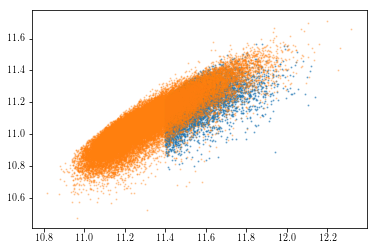

In [652]:
#param_test = params.sample()[0]
param_test = params.ini

param_test = np.array([0.61, 11.7, 0.01, 0.08, 0.67, -0.18 ,0.07])
print(param_test)

logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], param_test, min_logms=cfg['um']['min_logms'],
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

plt.scatter(logms_tot, logms_inn, s=1, alpha=0.5)
plt.scatter(obs_data['mtot'], obs_data['minn'], s=1, alpha=0.3)

In [653]:
predict_smf(logms_tot, logms_inn, sig_logms, cfg, min_weight=0.4)

(array([6.22398228e-05, 2.68886768e-05, 1.06937769e-05, 3.78372347e-06,
        1.15927592e-06, 3.01908090e-07, 4.56041935e-08]),
 array([3.54549041e-07, 1.82967647e-06, 7.50933218e-06, 2.25245025e-05,
        3.64164872e-05, 2.67137985e-05, 8.70386163e-06, 1.29447028e-06,
        1.17113766e-07, 5.23836112e-09]))

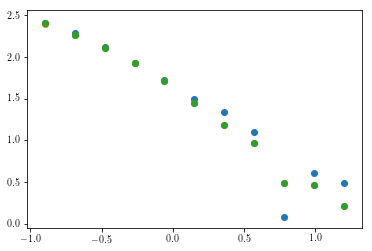

In [654]:
dsigma_noweight = predict_dsigma_profiles(
    cfg, obs_data['wl_dsigma'], um_data['um_mock'], um_data['um_mass_encl'], 
    logms_tot, logms_inn, mask=mask_use, sig_logms=None, min_num=3, add_stellar=False)

dsigma_weight = predict_dsigma_profiles(
    cfg, obs_data['wl_dsigma'], um_data['um_mock'], um_data['um_mass_encl'], 
    logms_tot, logms_inn, mask=mask_use, sig_logms=sig_logms, min_num=3, add_stellar=False)

dsigma_addstar = predict_dsigma_profiles(
    cfg, obs_data['wl_dsigma'], um_data['um_mock'], um_data['um_mass_encl'], 
    logms_tot, logms_inn, mask=mask_use, sig_logms=sig_logms, min_num=3, add_stellar=True)

plt.scatter(np.log10(obs_data['wl_dsigma'][11]['r_mpc']), np.log10(dsigma_noweight[11]))
plt.scatter(np.log10(obs_data['wl_dsigma'][11]['r_mpc']), np.log10(dsigma_weight[11]))
plt.scatter(np.log10(obs_data['wl_dsigma'][11]['r_mpc']), np.log10(dsigma_addstar[11]))

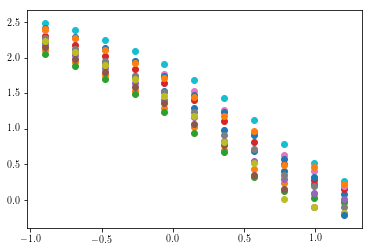

In [655]:
logr_mpc = np.log10(obs_data['wl_dsigma'][0]['r_mpc'])

[plt.scatter(logr_mpc, np.log10(mod)) for mod in dsigma_addstar]

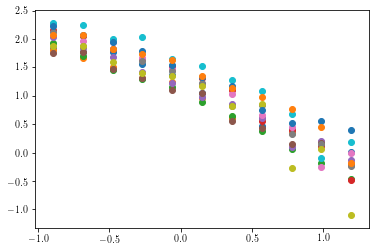

In [611]:
[plt.scatter(logr_mpc, np.log10(obs['dsigma'])) for obs in obs_data['wl_dsigma']]

In [656]:
um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(param_test, cfg, obs_data, um_data, verbose=True)

In [575]:
from asap import fitting
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, 
                              predict_dsigma_profiles, make_model_predictions)
 
config_file = '/Users/song/Dropbox/work/project/asap/asap/default_config.yaml'

results = fitting.fit_asap_model(config_file, verbose=True, debug=False)

# Running model: asap_mmax_m10_basic_test_A
#    Will use emcee as sampler ...
#    Use    32 walkers with    stretch moves for    10 x  1 steps of burn-in
#    Use    32 walkers with    stretch moves for    10 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_0.7124_new_vagc_mpeak_11.5.npy
# DSigma results : um_smdpl_0.7124_new_vagc_mpeak_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stellar mass: 
  11

100%|██████████| 7/7 [07:43<00:00, 62.87s/it]


#------------------------------------------------------
#  Mean acceptance fraction 0.040178571428571425
#------------------------------------------------------
#  Best ln(Probability): -3254.62080
[ 7.06518984e-01  1.15732170e+01  1.63018692e-02  5.94230658e-02
  7.63700211e-01 -3.39752064e-03  3.36538415e-01]
#------------------------------------------------------
(0.6041978876711929, 0.26336712626146896, 0.3993562160028624)
(11.346203814273341, 1.2453664523101615, 0.7834507990066726)
(0.003448988119750708, 0.05897429470125091, 0.05426940818445884)
(0.09353468791071531, 0.07780167550146747, 0.06241355353931864)
(0.6975790251787639, 0.18493055968303174, 0.2623371812871734)
(-0.18831638671874995, 0.186503751578699, 0.2927036554646216)
(0.2513512891028707, 0.21274040631738428, 0.15204721485941586)
#------------------------------------------------------

# Phase: Sampling Run ...


100%|██████████| 10/10 [14:41<00:00, 97.26s/it]

#------------------------------------------------------
#  Mean acceptance fraction 0.025
#------------------------------------------------------
#  Best ln(Probability):  -800.97133
[ 0.76766169 11.730521    0.1516084   0.15647739  0.8052876  -0.16272846
  0.10949055]
#------------------------------------------------------
(0.4344940944266972, 0.3772793497942871, 0.6292958059680469)
(11.316335448313197, 0.9533456597992735, 0.8290266731611808)
(-0.019777728777682115, 0.08449560431362299, 0.07824329597923943)
(0.11186418607588519, 0.08623530397802176, 0.07918334655793922)
(0.665907490055189, 0.1393801136815337, 0.2316899615555318)
(-0.26815308945992455, 0.15849150401867007, 0.2569315364218431)
(0.15200619756087494, 0.2850329478710967, 0.1815463556027304)
#------------------------------------------------------


In [562]:
burns, bsampler = results

io.save_results_to_npz(burns, bsampler, 'test.npz', 7, verbose=True)

#------------------------------------------------------
#  Mean acceptance fraction 0.08035714285714285
#------------------------------------------------------
#  Best ln(Probability): -2058.30977
[ 0.2740331  11.76146597  0.08145964  0.11492799  0.80359257 -0.04848538
  0.20796642]
#------------------------------------------------------
(0.628822760006171, 0.4093856820343479, 0.34379640758060276)
(11.514072208799094, 0.929336229600322, 0.8100952952451497)
(0.014930585009936699, 0.03327207415769171, 0.0684655447288464)
(0.10527436312372757, 0.05212636179381777, 0.08041105181364744)
(0.6657201081283493, 0.14808269093175785, 0.25370397353714275)
(-0.16899863144591315, 0.23521791479817722, 0.11948190485679433)
(0.24974253759023474, 0.1004803938547078, 0.10045024024431792)
#------------------------------------------------------


## Sandbox

In [9]:
from asap import io
from asap import smf 
from asap import config
from asap import fitting
from asap import ensemble
from asap import plotting
from asap.parameters import AsapParams
from asap.likelihood import ln_likelihood, ln_probability
from asap.predictions import (predict_mstar_basic, predict_smf, predict_mhalo,
                              predict_dsigma_profiles, make_model_predictions)

#config_file = '/Users/song/Dropbox/work/project/asap/asap/default_config.yaml'
config_file = 'test/test.yaml'

cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Running model: asap_mmax_m10_basic_test_A
#    Will use emcee as sampler ...
#    Use   128 walkers with    snooker moves for   200 x  1 steps of burn-in
#    Use   128 walkers with        kde moves for   200 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_0.7124_new_vagc_mpeak_11.5.npy
# DSigma results : um_smdpl_0.7124_new_vagc_mpeak_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stellar mass: 
  11

7


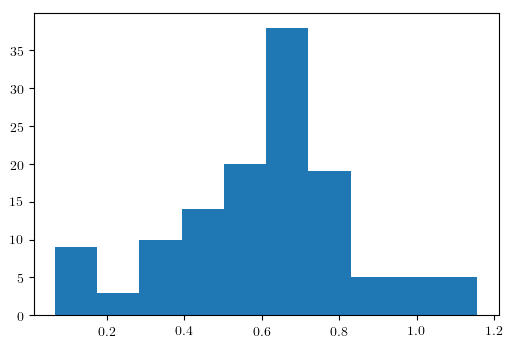

In [11]:
ini_positions = ensemble.setup_walkers(cfg['model']['emcee'], params, level=0.1)

print(ini_positions.shape[1])

_ = plt.hist(ini_positions[:, 0])

In [27]:
limits = np.array([params.low, params.upp])

In [29]:
limits[0].shape

(7,)

In [5]:
cProfile.run('ln_likelihood(params_rand, cfg, obs_data, um_data, sep_return=True)')

         26400 function calls (25956 primitive calls) in 0.094 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.094    0.094 <string>:1(<module>)
       36    0.000    0.000    0.000    0.000 <string>:2(_parse_args)
       24    0.000    0.000    0.000    0.000 _bsplines.py:18(prod)
       12    0.000    0.000    0.000    0.000 _bsplines.py:230(construct_fast)
       36    0.000    0.000    0.000    0.000 _bsplines.py:25(_get_dtype)
       12    0.000    0.000    0.000    0.000 _bsplines.py:312(__call__)
       36    0.000    0.000    0.000    0.000 _bsplines.py:33(_as_float_array)
       12    0.000    0.000    0.000    0.000 _bsplines.py:359(_evaluate)
       12    0.000    0.000    0.000    0.000 _bsplines.py:363(_ensure_c_contiguous)
       12    0.000    0.000    0.001    0.000 _bsplines.py:580(_not_a_knot)
       24    0.000    0.000    0.000    0.000 _bsplines.py:598(_convert_string_al

In [4]:
params_rand = params.sample(nsamples=1)[0]

print(params_rand)
print(params.lnprior(params_rand, nested=False))

ln_likelihood(params_rand, cfg, obs_data, um_data, sep_return=True)

[ 0.74991319 11.39094122 -0.17456203  0.0414508   0.56662923 -0.25994026
  0.14346557]
1.370915926077188


-inf

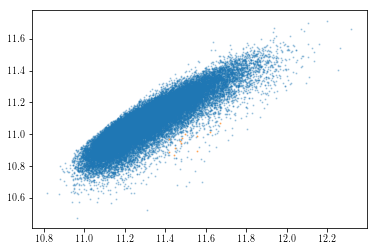

In [18]:
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], params_rand, min_logms=cfg['um']['min_logms'],
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=cfg['um']['pivot_logmh'])

plt.scatter(obs_data['mtot'], obs_data['minn'], s=1, alpha=0.3)
plt.scatter(logms_tot, logms_inn, s=1, alpha=0.5)

In [4]:
test_dir = 'test'

config_file = os.path.join(test_dir, 'test.yaml')

burnin_file = os.path.join(test_dir, 'burnin.npz')
result_file = os.path.join(test_dir, 'sample.npz')

cfg, params, obs_data, um_data = fitting.initial_model(config_file, verbose=True)

# Running model: asap_mmax_m10_basic_test_A
#    Will use emcee as sampler ...
#    Use   128 walkers with    stretch moves for   200 x  1 steps of burn-in
#    Use   128 walkers with        kde moves for   200 steps of sampling

# Observations:
# Galaxy catalog: s16a_wide2_massive_fsps1_imgsub_use_short.fits
# DSigma results: s16a_wide2_dsigma_logm11.6_12_bins.npy
# SMF of inner Mstar: s16a_wide2_massive_smf_m10_11.6.npy
# SMF of total Mstar: s16a_wide2_massive_smf_mmax_11.6.npy
# Covariances for SMFs: s16a_wide2_massive_smf_mmax_m10_cov.npy
# Reference SMF: primus_smf_z0.3_0.4.fits
# Column of inner Mstar: logm_10
# Column of total Mstar: logm_max

# UniverseMachine:
# Galaxy catalog : um_smdpl_0.7124_new_vagc_mpeak_11.5.npy
# DSigma results : um_smdpl_0.7124_new_vagc_mpeak_11.5_50m_r_0.08_50_22bins.npy
# Volumn of the simulation:    205348196.23 Mpc^3
# Halo mass : logmh_host
# Stellar mass : logms_tot
# There are 12 DSigma profiles in this sample
# SMF for total stellar mass: 
  11

In [5]:
(mod_burnin_samples, 
 mod_burnin_chains, 
 mod_burnin_lnprob, 
 mod_burnin_best, _, _) = io.load_npz_results(burnin_file)

(mod_result_samples, 
 mod_result_chains, 
 mod_result_lnprob, 
 mod_result_best, _, _) = io.load_npz_results(result_file)

print(np.nanmax(mod_burnin_lnprob), mod_burnin_best)
print(np.nanmax(mod_result_lnprob), mod_result_best)

from astropy.stats import sigma_clip

mod_samples_clip = sigma_clip(mod_result_samples, 1.0, cenfunc=np.nanmedian, stdfunc=np.nanstd, axis=0)

-163.5254521329434 [ 0.60393965  3.68803455  0.04945909  0.03582969  0.66610053 -0.17662113
  0.06018355]
-162.76278845276465 [ 0.60486966  3.67562995  0.09503779  0.03890565  0.66139332 -0.18487946
  0.05074987]


/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


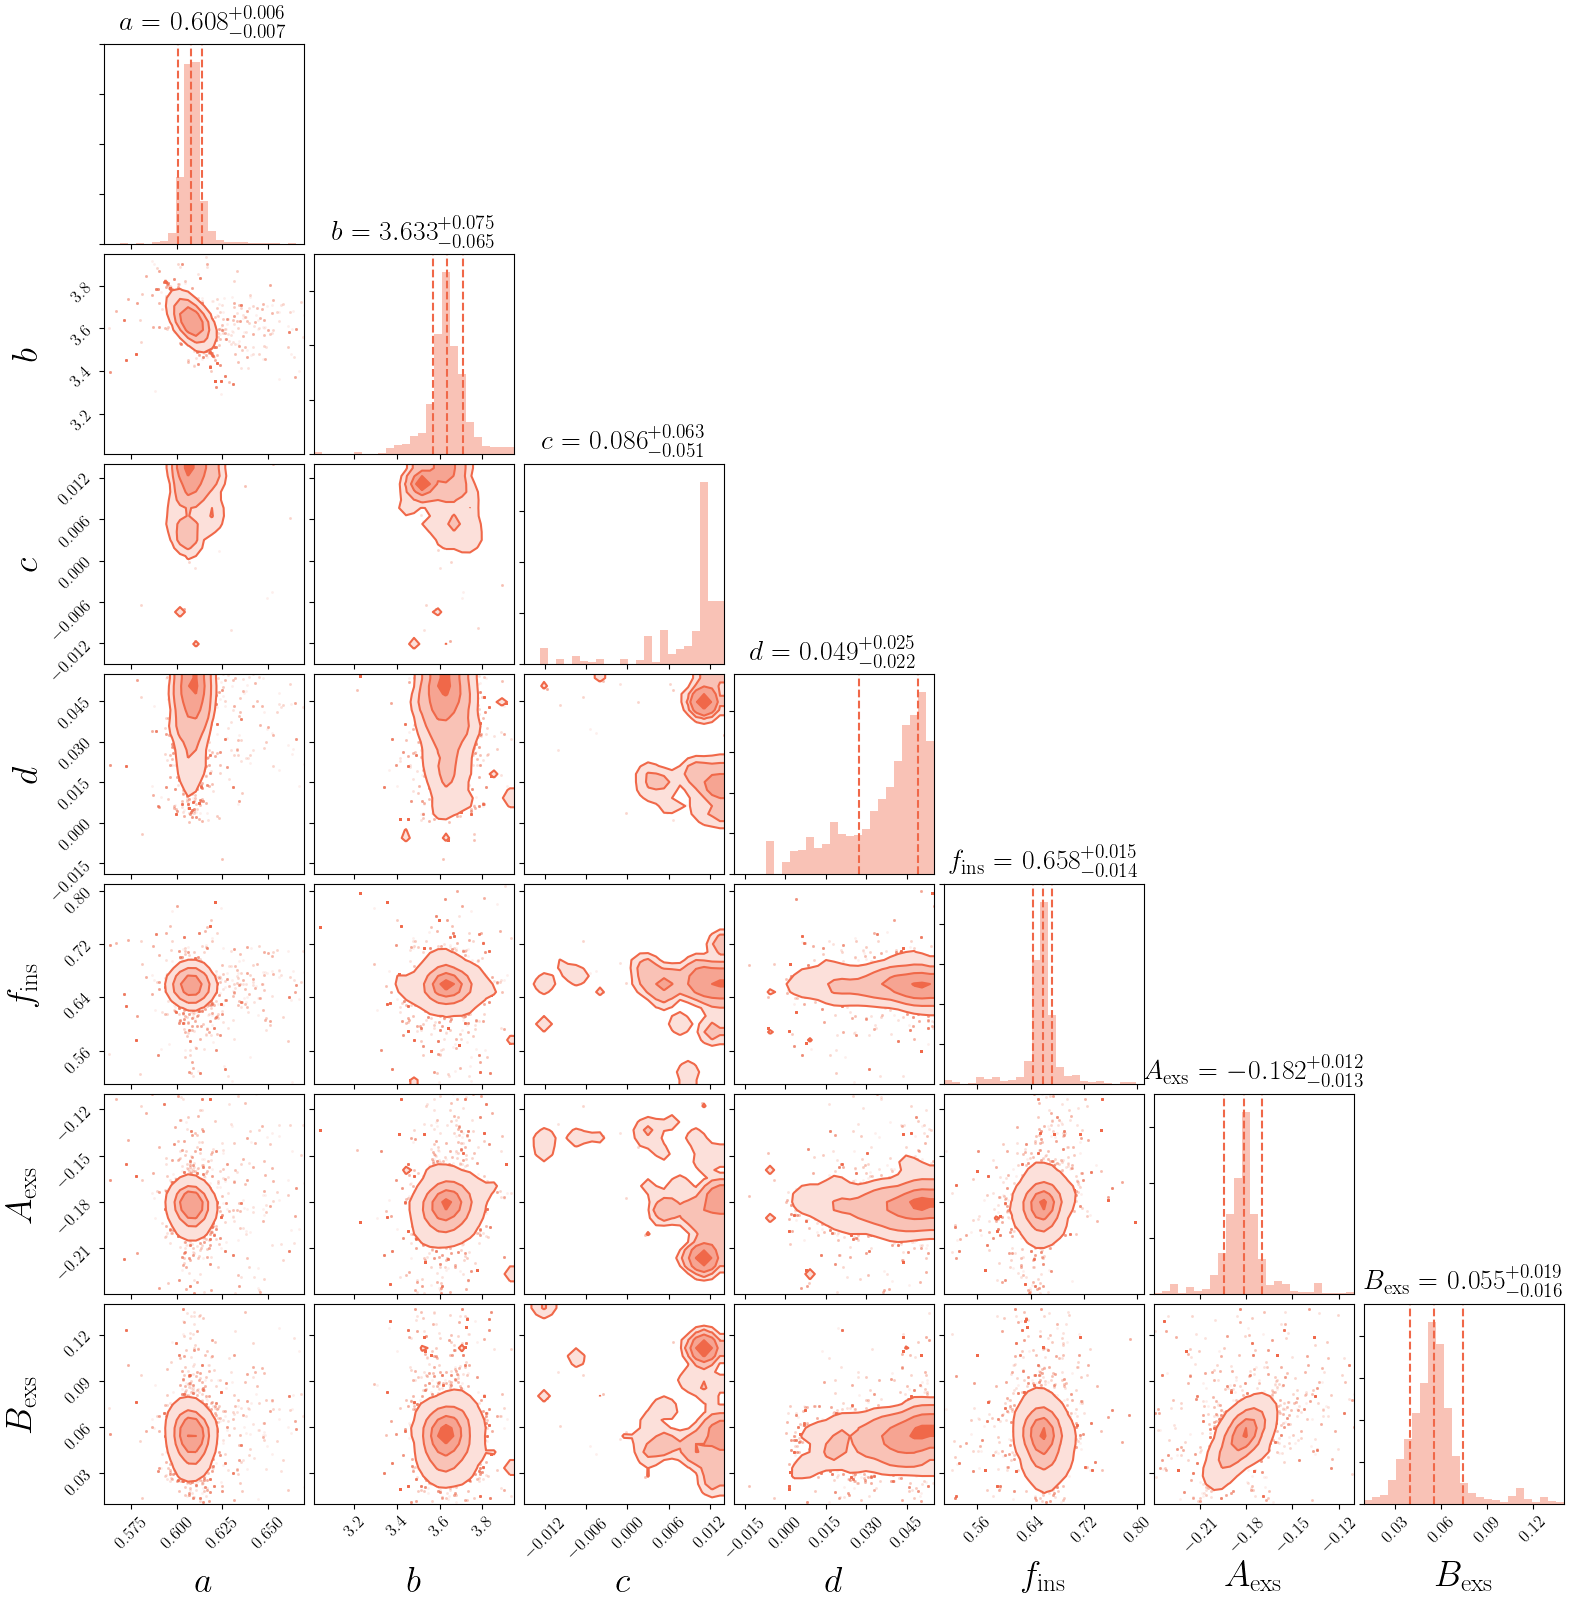

In [11]:
frac4_label = [r'$a$', r'$b$', r'$c$', r'$d$', 
               r'$f_{\rm ins}$', r'$A_{\rm exs}$', r'$B_{\rm exs}$']

frac4_range = [(0.56, 0.67), (3.01, 3.95), (-0.015, 0.014), (-0.019, 0.055), (0.51, 0.81), 
               (-0.24, -0.11), (0.01, 0.14)]
title_fmt = '.3f'

mod_corner = plotting.plot_mcmc_corner(
    mod_result_samples, frac4_label, **{'range': frac4_range, 'title_fmt': title_fmt})

/usr/local/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


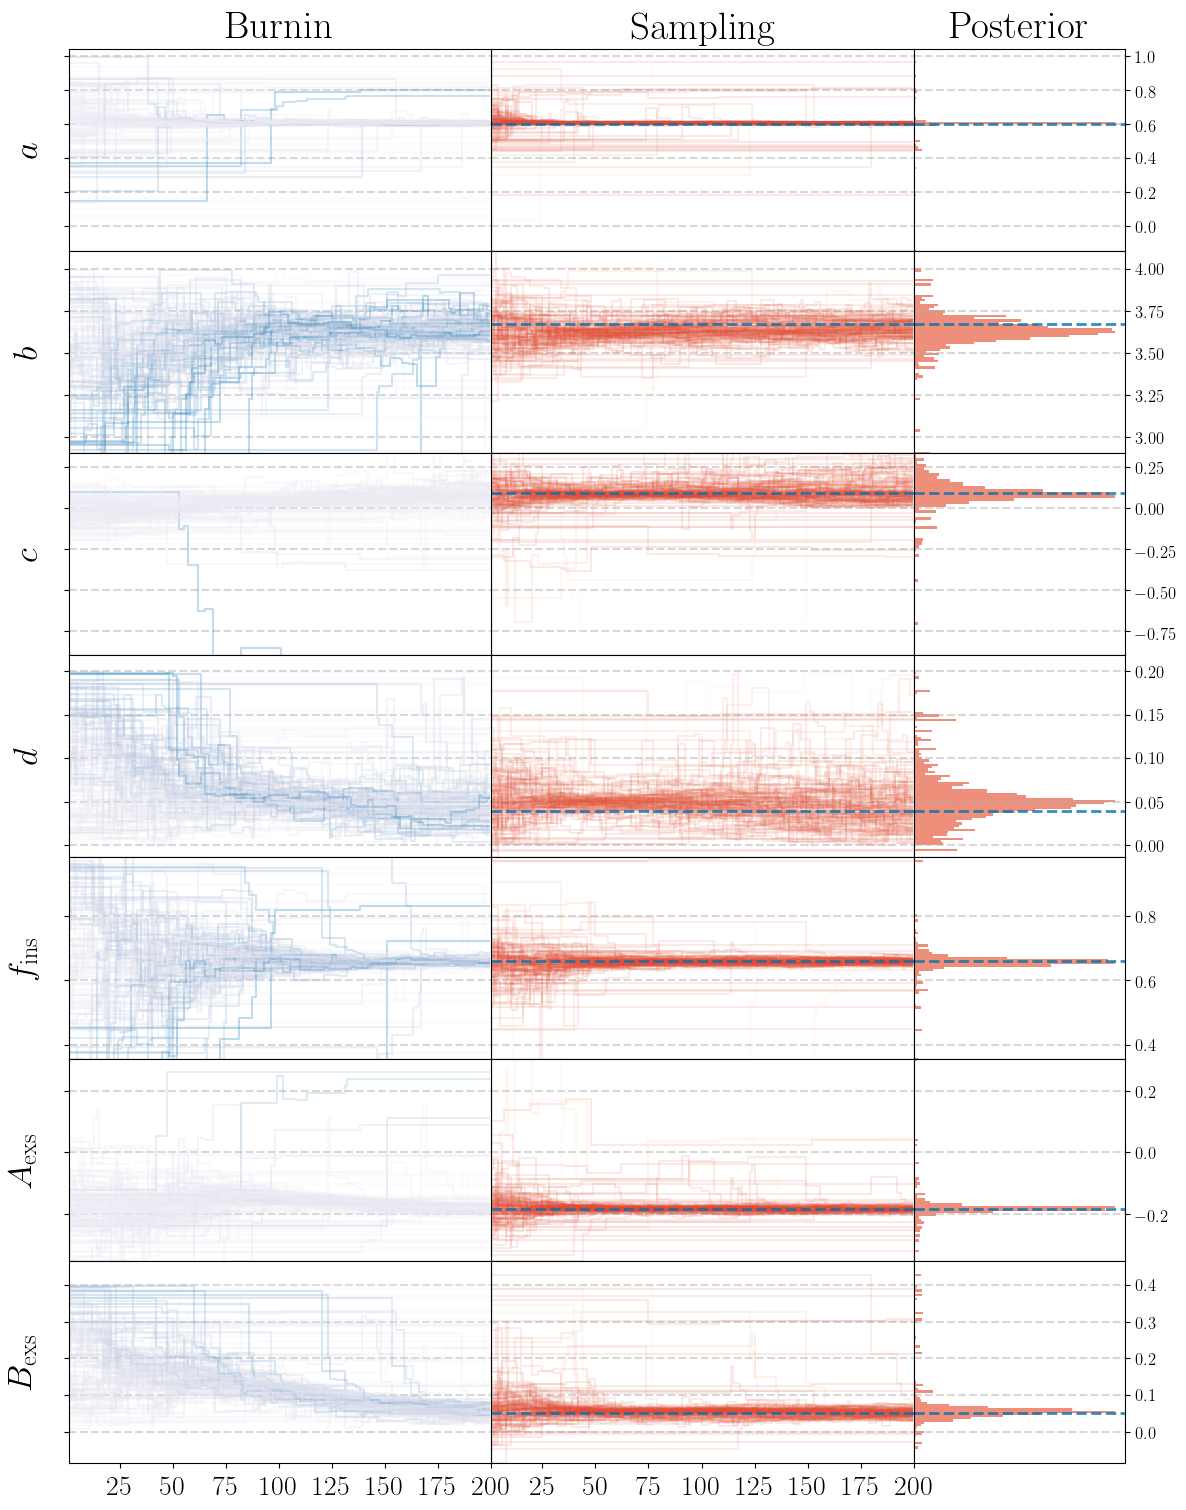

In [13]:
mod_trace = plotting.plot_mcmc_trace(
    mod_result_chains, frac4_label, mcmc_best=mod_result_best, mcmc_burnin=mod_burnin_chains, 
    burnin_alpha=0.25, trace_alpha=0.12)

In [6]:
logms_inn, logms_tot, sig_logms, mask_use = predict_mstar_basic(
    um_data['um_mock'], mod_result_best, min_logms=cfg['um']['min_logms'],
    logmh_col=cfg['um']['logmh_col'], min_scatter=cfg['um']['min_scatter'],
    pivot=0)

um_smf_tot, um_smf_inn, um_dsigma = make_model_predictions(mod_result_best, cfg, obs_data, um_data, verbose=True)

ln_likelihood(mod_result_best, cfg, obs_data, um_data, sep_return=True)

(190.2584798704961, -358.4568119631167)

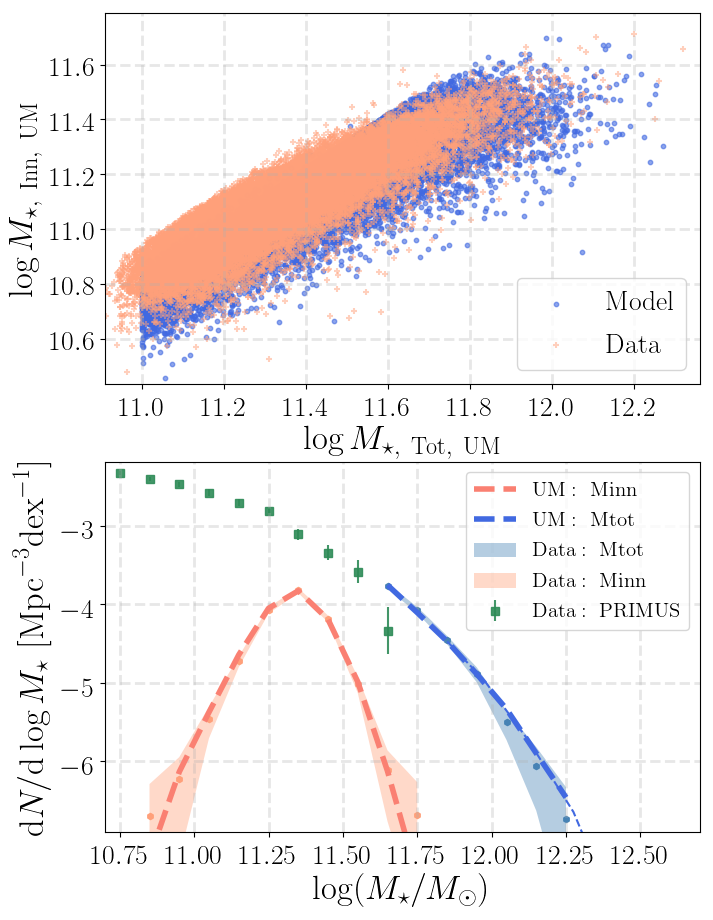

In [10]:
um_smf_tot_all = smf.get_smf_bootstrap(logms_tot, cfg['um']['volume'],
                                   10, 11.0, 12.5, n_boots=1)

mod_smf = plotting.plot_mtot_minn_smf(obs_data['smf_tot'], obs_data['smf_inn'],
                             obs_data['mtot'], obs_data['minn'],
                             um_smf_tot, um_smf_inn,
                             logms_tot, logms_inn,
                             obs_smf_full=obs_data['smf_full'],
                             um_smf_tot_all=um_smf_tot_all[5:],
                             not_table=True)

3 4 12


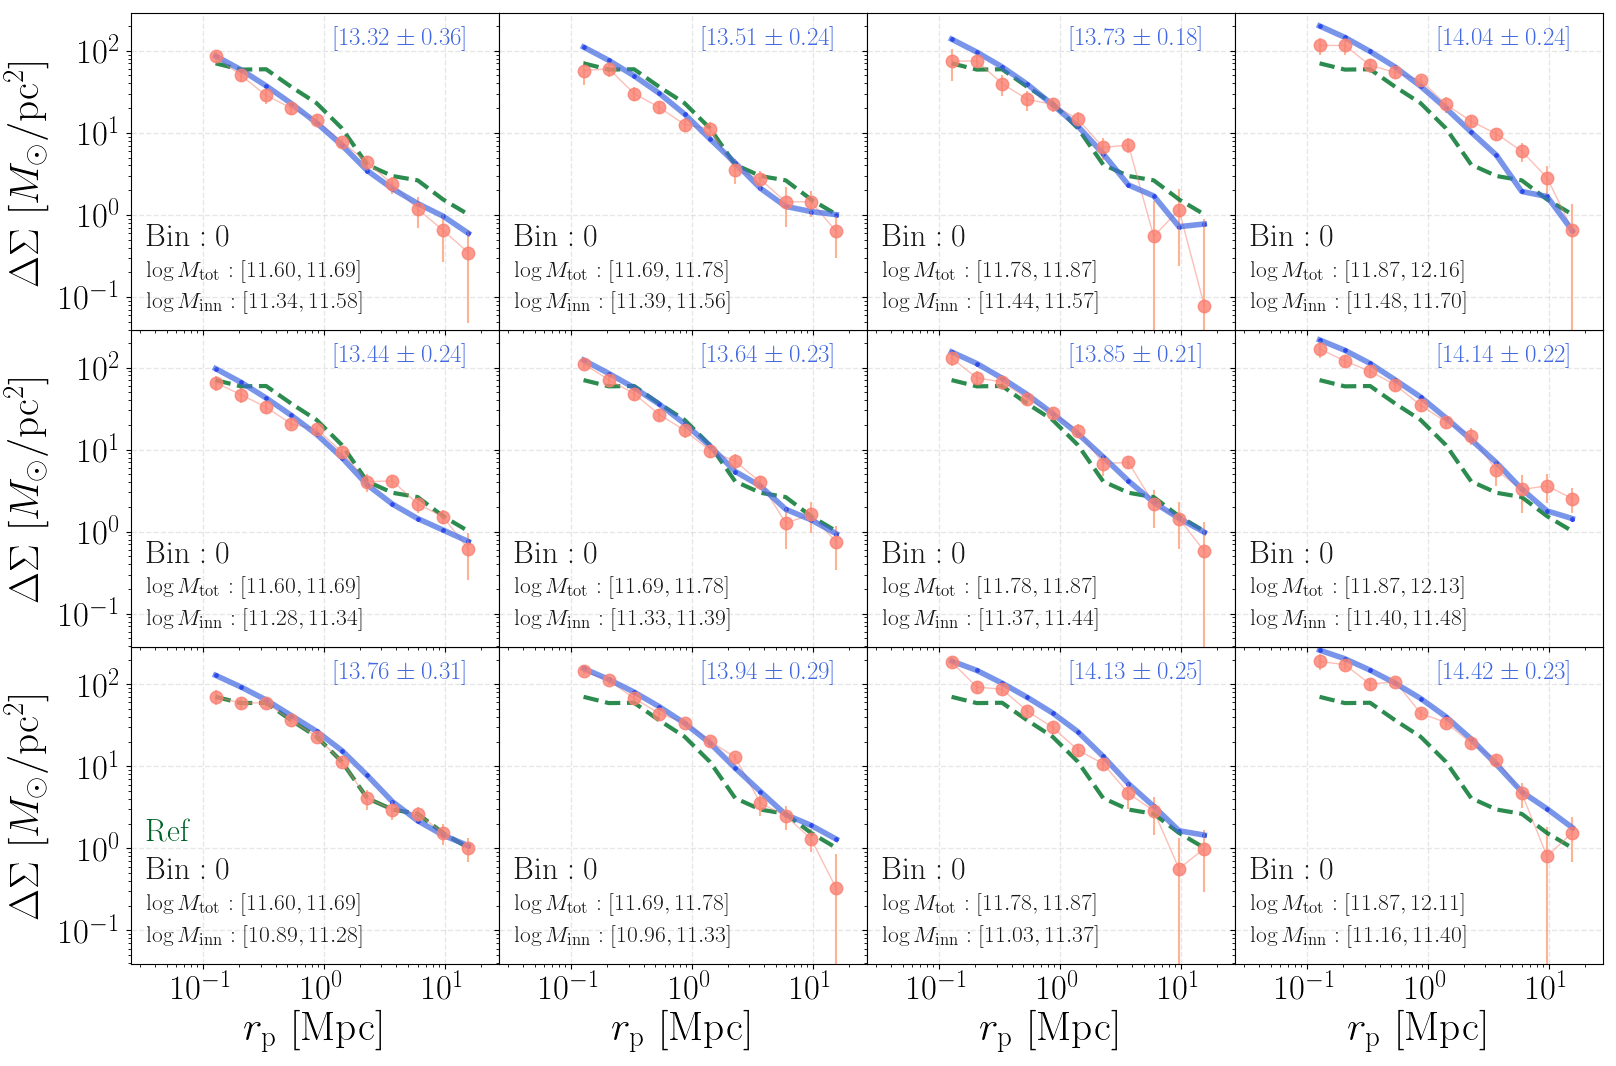

In [11]:
um_mhalo_tuple = predict_mhalo(obs_data['wl_dsigma'], um_data['um_mock'][mask_use], logms_tot, logms_inn)

mod_dsig = plotting.plot_dsigma_profiles(
    obs_data['wl_dsigma'], um_dsigma, um_mhalo=um_mhalo_tuple, reference=0)

/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/site-packages/astroML/stats/_binned_statistic.py:356: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


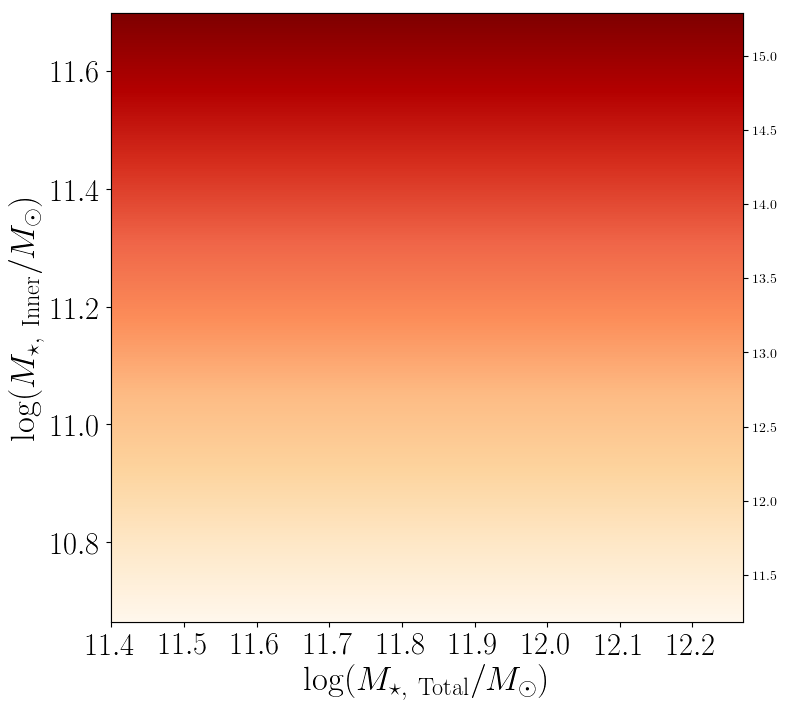

In [16]:
mask_logms = logms_tot >= 11.4

xx = logms_tot[mask_logms]
yy = logms_inn[mask_logms]
zz = um_data['um_mock']['logmh_vir'][mask_use]
zz = zz[mask_logms]

# Median halo mass
mod_mhalo = plotting.plot_mtot_minn_trend(
    xx, yy, zz, method=np.mean, x_bins=40, y_bins=35, n_contour=9)

# Scatter
#mod_sigmh = plotting.plot_mtot_minn_trend(xx, yy, zz, method=np.nanstd, contour=False,
#                                 x_bins=40, y_bins=35,
#                                 x_lim=[11.59, 12.2], y_lim=[10.81, 11.799], 
#                                 title=r'$\sigma(\log M_{\mathrm{Halo}})$',
#                                 z_max=0.25)

#mod_mhalo.savefig(os.path.join('fig', model_str + '_mtot_minn_mhalo.pdf'), dpi=120)
#mod_sigmh.savefig(os.path.join('fig', model_str + '_mtot_minn_sigmh.pdf'), dpi=120)

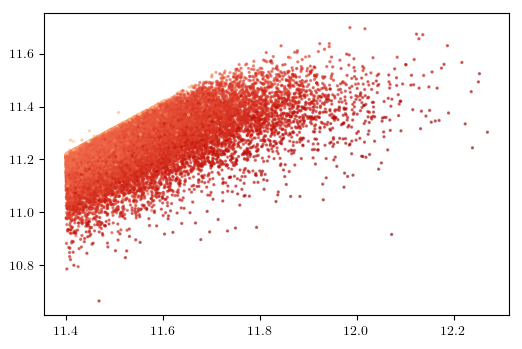

In [17]:
_ = plt.scatter(xx, yy, c=zz, cmap='OrRd', s=2, alpha=0.5)